# Proje: Face Mask Detection (Maske Tespiti)

Bu projenin amacı, bir görüntüdeki kişinin **maske takıp takmadığını** otomatik olarak tespit edecek bir derin öğrenme modeli eğitmektir. Çalışmada, Kaggle üzerinde paylaşılan **Face Mask Detection** veri seti kullanılmış ve transfer learning yaklaşımıyla önceden eğitilmiş bir model (örneğin DenseNet121) uyarlanarak sınıflandırma yapılmıştır.

## Proje Adımları

1. **Gerekli Kütüphanelerin Yüklenmesi**  
   - Başta `tensorflow`, `keras`, `numpy`, `pandas`, `matplotlib`, `seaborn`, `sklearn` gibi temel kütüphanelerimizi kurup içe aktarıyoruz.  
   - Ek olarak Kaggle’dan veri çekmek için `kaggle` CLI aracını kuruyoruz.

2. **Veri Seti Yükleme (Face Mask Detection Dataset)**  
   - Kaggle üzerinden veri setini doğrudan indirme ve zip dosyasını açma işlemleri yapılıyor.  
   - İndirilen veri seti proje klasörüne çıkartılarak eğitime hazır hâle getiriliyor.

3. **Model Mimarisi Oluşturma**  
   - Transfer learning için **DenseNet121** (veya MobileNet) gibi önceden eğitilmiş modeller `weights='imagenet'` argümanı ile temel (base) olarak alınıyor.  
   - Modele, üst katmana eklenecek ek **Dense** ve **Dropout** katmanlarıyla 2 sınıfa (with_mask / without_mask) ayrım yapacak son katman ekleniyor.  

4. **Veri Setinin Eğitim/Validasyon ve Test Olarak Ayrılması**  
   - Orijinal verinin `%20`'si test setine, kalan `%80`'lik kısım ise eğitim+validasyon için ayrılıyor.  
   - Eğitimin son aşamasında, eğitim+validasyon veri seti içerisinden tekrar `%80`'i eğitim ve `%20`'si validasyon olarak bölünüyor.  
   - Bu işlem, her sınıf (with_mask / without_mask) için dosyaları `train`, `val` ve `test` klasörlerine ayırarak gerçekleştiriliyor.

5. **Eğitim/Validasyon Setinin Bölünmesi ve Modelin Eğitilmesi**  
   - `ImageDataGenerator` ile eğitim verisinde çeşitli veri arttırma (rotation, shift, zoom, flip vb.) uygulanıyor; böylece modele çeşitlilik kazandırılıyor.  
   - Model `categorical_crossentropy` kayıp fonksiyonu ve `Adam` (learning_rate=0.001) optimizer ile derleniyor.  
   - `EarlyStopping` ile 25 epoch boyunca `val_loss` iyileşmezse eğitim duruyor.  
   - `ReduceLROnPlateau` ile validasyon kaybı iyileşmediğinde öğrenme oranı otomatik olarak düşürülüyor.  
   - `ModelCheckpoint` callback’i ile en iyi model kaydediliyor (ör. `best_model.keras`).

6. **Eğitim/Validasyon Accuracy ve Loss Grafiklerinin Raporlanması**  
   - Eğitim süreci sonunda `history` nesnesinden alınan **accuracy** ve **loss** değerleri çizdiriliyor.  
   - Ortaya çıkan grafikler sayesinde `training` ve `validation` performansının nasıl değiştiğini görebiliyoruz.

7. **Test Verisi ile Tahmin (Prediction) ve Sonuç Analizi**  
   - En iyi kayıtlı ağırlıklar (model) yüklenerek test setinde tahmin yürütülüyor.  
   - Elde edilen tahminler (with_mask / without_mask) ile gerçek etiketler karşılaştırılıp **Confusion Matrix**, **Classification Report** (accuracy, precision, recall, f1-score) hesaplanıyor.  
   - **ROC** (Receiver Operating Characteristic) eğrisi ve **AUC** (Area Under Curve) değeri de raporlanarak sınıflandırma kalitesi detaylı inceleniyor.

## Sonuç

Model, test verileri üzerinde oldukça yüksek doğruluk oranına (yaklaşık %99–%100) ulaşmıştır. Bu sonuç, veri setinin net görseller içermesi ve transfer learning’in gücü sayesinde gerçekleşmiştir. Gerçek senaryolarda, farklı açılar ve çeşitli koşullarda çekilmiş yeni görsellerle modeli test etmek gerekebilir. Bu aşamalarla birlikte, **Face Mask Detection** görevini başarıyla gerçekleştiren bir derin öğrenme modeli elde edilmiştir.


## 1. Gerekli Kütüphanelerin Yüklenmesi
* İlk olarak proje boyunca ihtiyaç duyacağımız kütüphaneleri yükleyelim.

In [1]:
!pip install kaggle
!pip install tensorflow
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pre-trained modeller
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import MobileNet

import tensorflow as tf

## 2. Veri Seti Yükleme (Face Mask Detection Dataset)
Kaggle’dan veri setinin indirilmesi

In [3]:
from google.colab import files
!mkdir ~/.kaggle

# Veri setini indirme
!kaggle datasets download -d omkargurav/face-mask-dataset

# İndirdiğiniz zip dosyasını açma
!unzip face-mask-dataset.zip -d face_mask_dataset


mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  face-mask-dataset.zip
replace face_mask_dataset/data/with_mask/with_mask_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## 3. Önceden Eğitilmiş (Pre-trained) Modellerin Hazırlanması
Projede DenseNet121’i kullanarak bir model oluşturulmuştur.

In [4]:
IMAGE_SIZE = (224, 224)

base_model = DenseNet121(weights='imagenet',
                         include_top=False,
                         input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Base model'in son katmanından çıkan aktivasyon haritalarının alınması
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

# Ek dense katmanları
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# Çıkış katmanı (2 sınıf: With Mask (0), Without Mask (1))
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


## 4. Veri Setinin Eğitim/Validasyon ve Test Olarak Ayrılması

Toplam verinin %20’sini test set olarak ayıracağız. Geri kalan %80’i ise eğitim+validasyon şeklinde kullanacağız.

#### Klasör Bazlı Ayırma:

In [5]:
import shutil
import os
from glob import glob

data_dir = 'face_mask_dataset/data'
classes = ['with_mask', 'without_mask']

# Hedef klasörlerin oluşturulması
os.makedirs('dataset/train/with_mask', exist_ok=True)
os.makedirs('dataset/train/without_mask', exist_ok=True)
os.makedirs('dataset/val/with_mask', exist_ok=True)
os.makedirs('dataset/val/without_mask', exist_ok=True)
os.makedirs('dataset/test/with_mask', exist_ok=True)
os.makedirs('dataset/test/without_mask', exist_ok=True)

test_size = 0.20  # %20 test
val_size = 0.20   # Train+Val'in içinde %20 validation

for cls in classes:
    all_images = glob(os.path.join(data_dir, cls, '*.png')) + \
                 glob(os.path.join(data_dir, cls, '*.jpg')) + \
                 glob(os.path.join(data_dir, cls, '*.jpeg'))

    # 1) Test ayırma
    train_val_files, test_files = train_test_split(all_images,
                                                   test_size=test_size,
                                                   random_state=42)

    # 2) Train ve Validation ayırma (train_val_files içerisinden %20'si validation)
    train_files, val_files = train_test_split(train_val_files,
                                              test_size=val_size,
                                              random_state=42)

    # Dosyaların ilgili klasörlere kopyalanması
    for f in train_files:
        shutil.copy(f, f'dataset/train/{cls}')
    for f in val_files:
        shutil.copy(f, f'dataset/val/{cls}')
    for f in test_files:
        shutil.copy(f, f'dataset/test/{cls}')


## 5. Eğitim/Validasyon Setinin Bölünmesi ve Modelin Eğitilmesi

Artık train, val klasörlerimizde eğitim ve doğrulama verimiz hazır. Bu veriler üzerinde data augmentation (veri arttırımı) uygulayacağız ve modelimizi eğiteceğiz.

#### ImageDataGenerator ile Veri Yükleme:

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir = 'dataset/train'
val_dir = 'dataset/val'
test_dir = 'dataset/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 4833 images belonging to 2 classes.
Found 1209 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


#### Modelin Derlenmesi (Compile) ve Callback’lerin Ayarlanması
* EarlyStopping: patience=25
* ReduceLROnPlateau: Validasyon kaybı iyileşmeyince LR’i otomatik düşürecek

In [7]:
# Optimizer seçimi
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=25,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              verbose=1)

# Modelin en iyi epoch'ta kaydedilmesi
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


#### Modelin Eğitimi
* Modeli 100 epoch boyunca eğitiyoruz.

In [8]:
epochs = 100
train_steps = train_generator.samples // train_generator.batch_size
val_steps = val_generator.samples // val_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/151 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8915 - loss: 0.2591

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.9056 - loss: 0.2312
Epoch 1: val_loss improved from inf to 0.13482, saving model to best_model.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 316s 937ms/step - accuracy: 0.9059 - loss: 0.2307 - val_accuracy: 0.9637 - val_loss: 0.1348 - learning_rate: 0.0010
Epoch 2/100
  1/151 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9375 - loss: 0.3638

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.13482
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.9375 - loss: 0.3638 - val_accuracy: 0.8800 - val_loss: 0.1660 - learning_rate: 0.0010
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9678 - loss: 0.0895
Epoch 3: val_loss improved from 0.13482 to 0.11289, saving model to best_model.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 56s 355ms/step - accuracy: 0.9678 - loss: 0.0896 - val_accuracy: 0.9620 - val_loss: 0.1129 - learning_rate: 0.0010
Epoch 4/100
  1/151 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 1.0000 - loss: 0.0129
Epoch 4: val_loss improved from 0.11289 to 0.00529, saving model to best_model.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9753 - loss: 0.0675
Epoch 5: val_loss did not improve from 0.00529
151/151 ━━━━━━━━━━━━━━━━━━━━ 54s 341ms/

# 6. Eğitim/Validasyon Accuracy ve Loss Grafiklerinin Raporlanması
Eğitim süreci boyunca elde edilen kayıp (loss) ve doğruluk (accuracy) değerlerinin grafiklerinin çizilmesi.

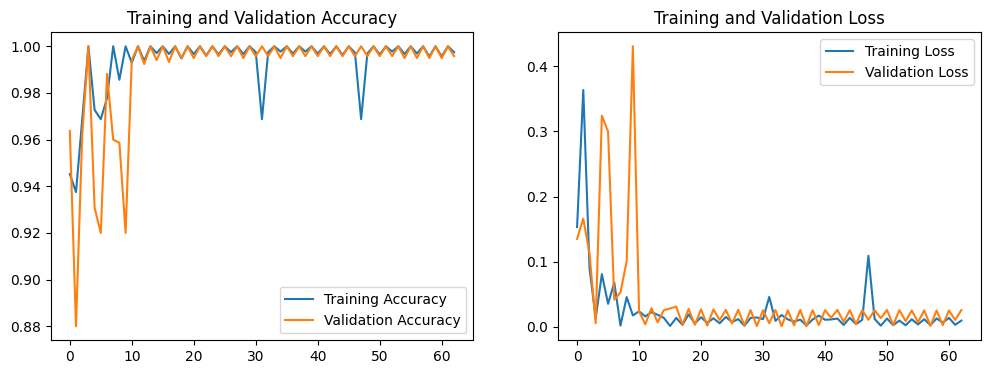

In [9]:
num_epochs = min(len(history.history['accuracy']), len(history.history['val_accuracy']))

acc = history.history['accuracy'][:num_epochs]
val_acc = history.history['val_accuracy'][:num_epochs]
loss = history.history['loss'][:num_epochs]
val_loss = history.history['val_loss'][:num_epochs]

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## 7. Test Verisi ile Tahmin (Prediction) ve Sonuç Analizi

In [10]:
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Tahminlerin en yüksek olasılığa sahip sınıf indeksini bulalım
predicted_classes = np.argmax(predictions, axis=1)

# True classes (flow_from_directory shuffle=False olduğu için indices sıralı)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 366ms/step


### 7.1. Confusion Matrix ve Klasik Metrikler

Confusion Matrix:
[[742   3]
 [  5 761]]


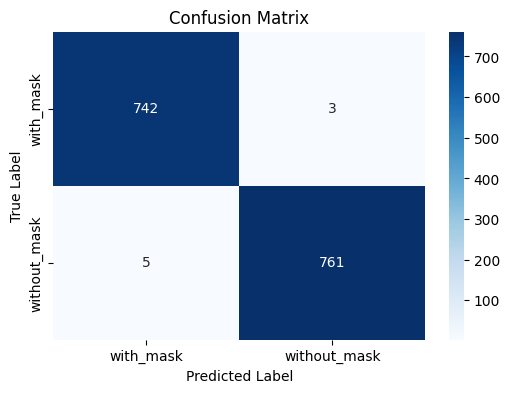

Classification Report:
              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       745
without_mask       1.00      0.99      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511

Specificity: 0.9959731543624161


In [11]:
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Specificity
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

specificity = TN / (TN + FP)
print("Specificity:", specificity)


### 7.2. ROC Eğrisi ve AUC

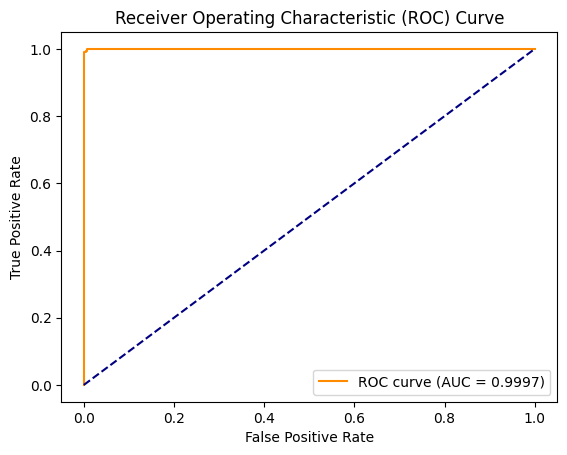

AUC:  0.9997161231534862


In [12]:
# Gerçek etiketleri 0/1 şeklinde, predicted prob'ları alıyoruz
fpr, tpr, thresholds = roc_curve(true_classes, predictions[:,1])  # sınıf 1 için olasılıklar
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("AUC: ", roc_auc)

## 8. Sonuçlar ve Yorumlar

Bu aşamada, eğitilen modelin test sonuçları incelenmiş ve **Confusion Matrix**, **Classification Report** ile **ROC-AUC** değerleri üzerinden performans değerlendirmesi yapılmıştır. Ayrıca eğitim sürecinde kullanılan hiperparametreler ve elde edilen performans sonuçları kısaca yorumlanmıştır.

### **8.1. Confusion Matrix ve Performans Metrikleri**

|               | Predicted: With Mask | Predicted: Without Mask |
|---------------|----------------------:|-------------------------:|
| **Actual: With Mask**    |              742       |                  3       |
| **Actual: Without Mask** |               5        |                 761      |

- **Accuracy**: \(\approx 0.99\)  
- **Precision (With Mask)**: 0.99  
- **Recall (With Mask)**: 1.00  
- **Precision (Without Mask)**: 1.00  
- **Recall (Without Mask)**: 0.99  
- **F1-Score**: \(\approx 0.99\) (her iki sınıf için)  
- **Specificity**: 0.9959  
- **AUC**: 0.9997  

Bu değerler, modelin **maskeli** ve **maskesiz** yüzleri ayırt etmede neredeyse mükemmele yakın bir performans sergilediğini göstermektedir. Confusion matrix incelendiğinde, yanlış sınıflandırma oranının çok düşük olduğu görülmektedir.

### **8.2. Eğitim Süreci ve Hiperparametre Denemeleri**

1. **Öğrenme Oranı (Learning Rate)**  
   - Başlangıçta `learning_rate = 0.001` kullanılmış, `ReduceLROnPlateau` callback’i ile validasyon kaybı iyileşmeyince LR kademeli olarak `1e-04`, `1e-05`, ... düzeyine düşürülmüştür.  
   - İlerleyen epoch’larda öğrenme hızı çok küçük değerlere indiğinde modelin validasyon kaybı aşırı düşük seviyelere (örneğin 0.00054) ulaşmıştır.

2. **Epoch ve Early Stopping**  
   - Model 100 epoch’a kadar eğitilmiştir ancak **EarlyStopping** mekanizması ve öğrenme oranı azalmaları sebebiyle etkin bir şekilde durdurma veya çok yavaş öğrenme süreci gözlenmiştir.  
   - Yüksek epoch sayısına rağmen validasyon kaybının erken evrelerde çok düşük değerlere indiği görülmektedir.

3. **Model Seçimi (DenseNet121 ve Transfer Learning)**  
   - DenseNet121 gibi güçlü bir önceden eğitilmiş ağ kullanmak, nispeten “kolay” sayılabilecek bir veri setinde çok yüksek doğruluk sağlamıştır.  
   - Eklenen üst katmanlar (Dense, Dropout) ile son katmandaki 2 sınıflı ayrım başarılı bir şekilde optimize edilmiştir.

4. **Veri Arttırımı (Data Augmentation)**  
   - Eğitim verisine uygulanan dönme, kaydırma, yakınlaştırma ve yatay çevirme gibi işlemler sayesinde model genel bir esnekliğe kavuşmuştur.  
   - Buna rağmen, veri setinin net yapısı ve modelin kapasitesi sebebiyle doğruluk zaten çok yüksek seyretmektedir.

5. **Eğitimde “ran out of data” Uyarısı**  
   - Bazı epoch’larda “input ran out of data” şeklinde uyarılar görülmüştür. Bu genellikle `steps_per_epoch` veya batch/kopya sayısının tam eşleşmemesinden kaynaklanır. Yine de eğitim ve validasyon sonuçları elde edilmiş ve model performansı yüksek çıkmıştır.

### **8.3. Genel Değerlendirme**

- Model, test verisinde **\(\approx 99\%\)** doğruluk, **\(\approx 0.9997\)** AUC değeri gibi son derece güçlü sonuçlar elde etmiştir.  
- Verinin görece net olması, maskeli ve maskesiz yüzlerin kolay ayırt edilebilir özellikler içermesi ve DenseNet121 gibi kuvvetli bir taban ağı kullanılması bu başarıdaki önemli etkenlerdir.  
- Öğrenme oranı düşürülerek modelin overfitting eğilimi düşük seviyede tutulmuş, çok küçük val_loss değerlerine ulaşılabilmiştir.

Özetle, **hiperparametre ayarları** (learning rate, erken durdurma, veri arttırımı vb.) ve **DenseNet121** temelli transfer learning yaklaşımı sayesinde **Face Mask Detection** görevi için son derece başarılı bir sınıflandırıcı elde edilmiştir. Gerçek dünyada farklı aydınlatma, açı ve maske şekilleri gibi değişken koşullar test edilerek modelin genellenebilirliği daha kapsamlı şekilde değerlendirilebilir.
